In [1]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.stat.machinelearning import binary_classifier
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.plotting import imshow

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.stat_lib import test_quantity, rstest_twosided
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-neuro/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
# params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
# params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


In [29]:
signCellsMaintenance = SignificantCells('significant_cells_deconv_mt.h5').get_cells_by_mouse()
print("Maintenance cells")
print(signCellsMaintenance)


nCellsByMouse = {mousename : dataDB.get_nchannel(mousename, 'raw') for mousename in sorted(dataDB.mice)}
signCellsNoReward = SignificantCells('significant_cells_deconv_enc_reward.h5').get_cells_by_mouse_inverse(nCellsByMouse)
print("No Reward cells")
print(signCellsNoReward)

significantCellsSelector = {
    'None' : None,
    'Maintenance' : signCellsMaintenance,
    'NoReward' : signCellsNoReward
}

Maintenance cells
{'m060': array([ 0,  3,  4,  5,  6,  7,  9, 10, 11, 14, 16, 18, 19, 20, 21, 23, 24,
       26, 27, 29, 30, 31, 32, 35, 39, 40, 41, 42, 43, 44, 45, 47, 48, 50,
       52, 55, 56, 57, 58, 60, 63, 64, 65, 67, 71, 74, 79, 80, 81, 82, 83,
       85]), 'm061': array([ 6,  7,  9, 11, 13, 14, 18, 19, 20, 21, 24, 26, 27, 28, 29, 32, 33,
       34, 35, 36, 37, 39, 40, 42, 43, 44]), 'm065': array([ 4,  6,  9, 10, 12, 13, 14, 15, 16, 19, 22, 25, 26, 30, 31, 32, 34,
       36, 38, 39, 41, 45, 46, 47, 51, 53, 54, 55, 57, 58, 59, 60, 65, 66,
       68, 69, 70, 71, 72, 73, 76, 78, 79]), 'm066': array([ 1,  2,  3,  4,  7,  8, 12, 13, 18, 21, 25, 27, 30, 31, 32, 34, 36,
       40, 41, 42, 45, 46]), 'm067': array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 16, 17, 18, 19, 20,
       21, 22, 23, 26, 28, 29, 30, 32, 33, 34, 35, 37, 38, 39, 41, 42, 43,
       44, 45, 47, 48]), 'm068': array([ 3,  5, 10, 12, 14, 16, 19, 23, 24, 26, 27])}
No Reward cells
{'m060': array([ 0,  3,  4,  5, 

# 1. Neuron-Time-Average

**Goal**: Attempt to predict L/R and C/M from mean activity over trial

**VERY IMPORTANT**: When we compare significant cells, we must compare exactly the same cells in each condition. So, we must select all cells significant within that interval/phase

In [30]:
def test_mean_time_and_neurons(dataDB, datatype, selector, condition, signCellsMouseDict=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    testResults = []
    
    fig, ax = plt.subplots(ncols=nMice, figsize=(4*nMice, 4))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        
        if signCellsMouseDict is not None:
            channelFilter = signCellsMouseDict
            nChannels = len(signCellsMouseDict[mousename])
        else:
            channelFilter = None
            nChannels = dataDB.get_nchannel(mousename, datatype)
            
        for condVal in condValues:
            queryDictCond = {"datatype" : datatype, "mousename" : mousename, condition : condVal}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "r", selector, {}, channelFilter=signCellsMouseDict)]

        meanVals = [np.mean(mu) for mu in means]
        nTrialsCond = tuple(len(mu) for mu in means)
        negLogPVal = -np.log10(rstest_twosided(*means)[1])
        
                
        testResults += [[mousename, *meanVals, nTrialsCond, nChannels, negLogPVal]]
        ax[iMouse].violinplot(means)
        ax[iMouse].set_title(mousename)
        
    display(pd.DataFrame(testResults, columns=["mouse", *condValues, "nTrials", "nNeurons", "-log10(pval)"]))
    plt.show()

6 performance ; Significant Cells : None


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.067759,0.067734,"(20, 133)",88,0.096210
1,m061,0.084562,0.082701,"(16, 74)",46,0.220840
2,m065,0.140185,0.137333,"(57, 181)",83,0.044947
3,m066,0.145734,0.132018,"(37, 151)",47,0.985166
4,m067,0.096563,0.098013,"(43, 154)",49,0.201053
5,m068,0.105800,0.114815,"(63, 175)",28,1.424139


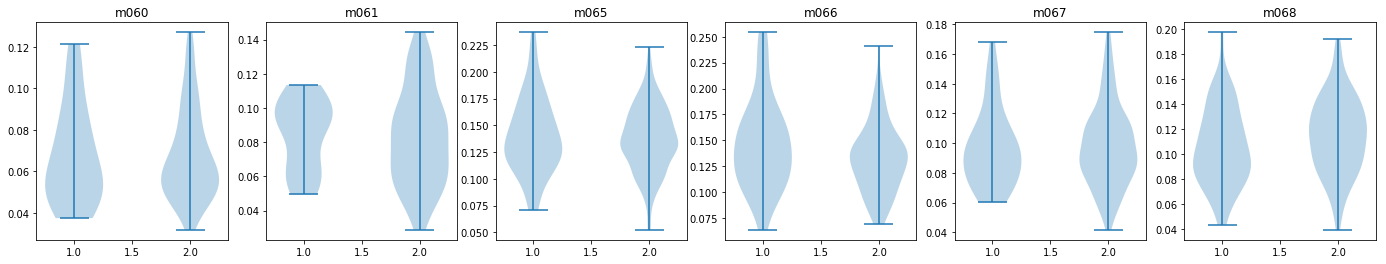

6 performance ; Significant Cells : Maintenance


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.077018,0.076110,"(20, 133)",52,0.054689
1,m061,0.088082,0.088394,"(16, 74)",26,0.005520
2,m065,0.173419,0.168804,"(57, 181)",43,0.127425
3,m066,0.162849,0.148332,"(37, 151)",22,0.364334
4,m067,0.101151,0.101684,"(43, 154)",38,0.155086
5,m068,0.088690,0.101253,"(63, 175)",11,1.397096


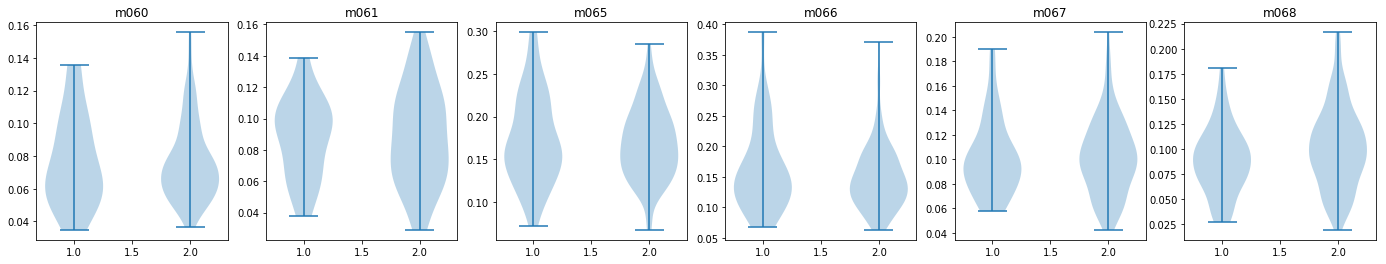

6 performance ; Significant Cells : NoReward


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.078085,0.078647,"(20, 133)",48,0.016236
1,m061,0.087813,0.085201,"(16, 74)",38,0.322171
2,m065,0.157862,0.153326,"(57, 181)",62,0.090613
3,m066,0.163968,0.140782,"(37, 151)",32,1.512784
4,m067,0.086636,0.086711,"(43, 154)",36,0.075432
5,m068,0.119494,0.134106,"(63, 175)",14,1.534851


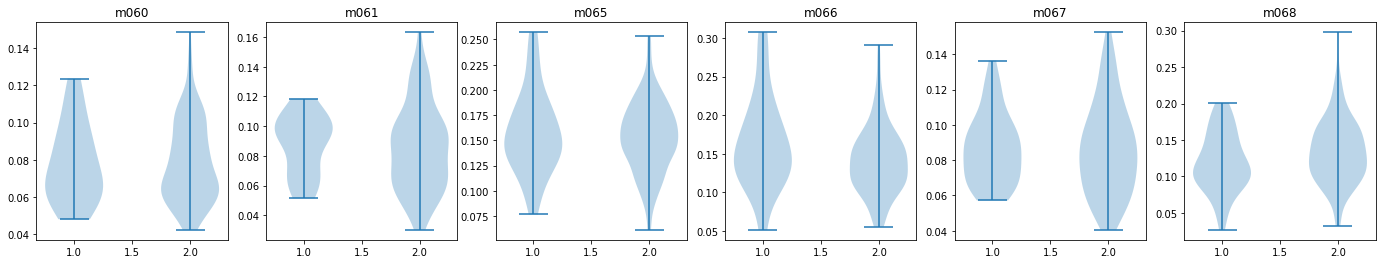

6 direction ; Significant Cells : None


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.066050,0.069540,"(79, 74)",88,0.266923
1,m061,0.090792,0.075272,"(45, 45)",46,2.205782
2,m065,0.130920,0.145479,"(122, 116)",83,3.202687
3,m066,0.137470,0.132397,"(86, 102)",47,0.374757
4,m067,0.098657,0.096890,"(90, 107)",49,0.378318
5,m068,0.110011,0.115149,"(126, 112)",28,0.898548


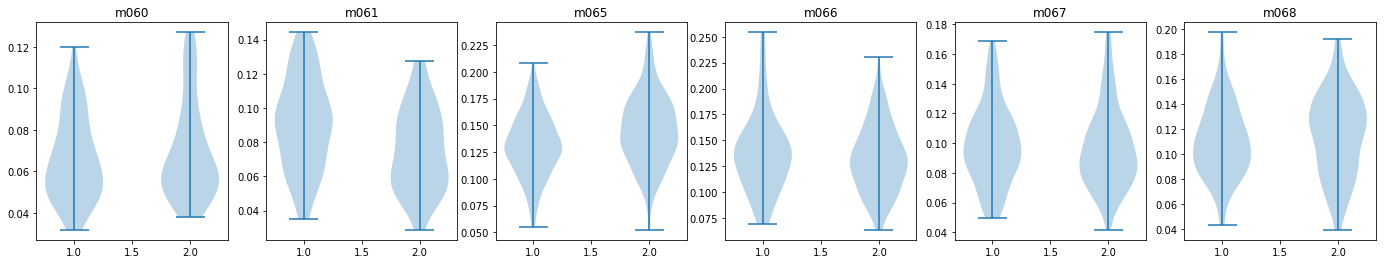

6 direction ; Significant Cells : Maintenance


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.074199,0.078396,"(79, 74)",52,0.327093
1,m061,0.099045,0.077633,"(45, 45)",26,3.335973
2,m065,0.157487,0.182974,"(122, 116)",43,4.615987
3,m066,0.157978,0.145466,"(86, 102)",22,0.822652
4,m067,0.103064,0.100308,"(90, 107)",38,0.584144
5,m068,0.097362,0.098563,"(126, 112)",11,0.020396


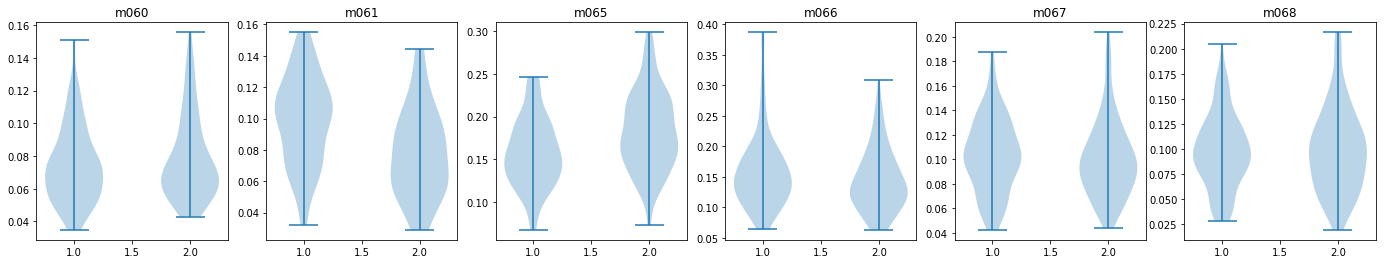

6 direction ; Significant Cells : NoReward


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.080025,0.077024,"(79, 74)",48,0.797780
1,m061,0.093934,0.077398,"(45, 45)",38,2.248586
2,m065,0.145651,0.163627,"(122, 116)",62,4.003248
3,m066,0.146158,0.144660,"(86, 102)",32,0.020509
4,m067,0.086741,0.086656,"(90, 107)",36,0.075743
5,m068,0.126872,0.134024,"(126, 112)",14,0.689051


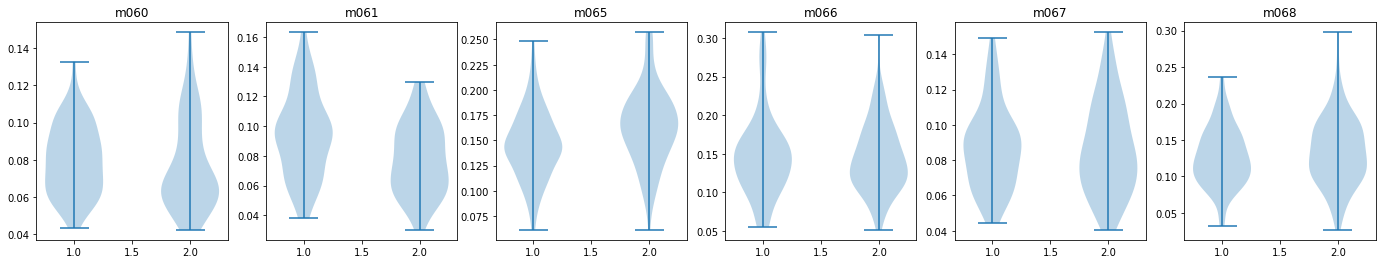

7 performance ; Significant Cells : None


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.081328,0.079091,"(20, 133)",88,0.191427
1,m061,0.119230,0.115873,"(16, 74)",46,0.184570
2,m065,0.129072,0.132361,"(57, 181)",83,0.289238
3,m066,0.147504,0.143915,"(37, 151)",47,0.212474
4,m067,0.121338,0.121481,"(43, 154)",49,0.076656
5,m068,0.076065,0.076176,"(63, 175)",28,0.143658


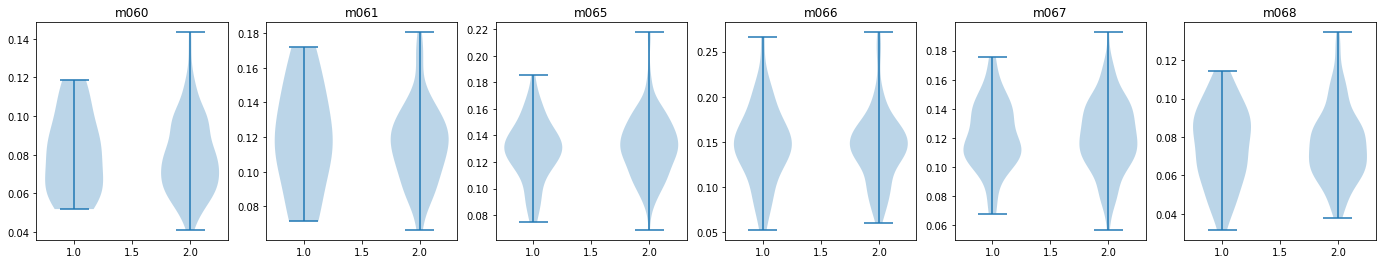

7 performance ; Significant Cells : Maintenance


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.096036,0.094891,"(20, 133)",52,0.078348
1,m061,0.146629,0.146848,"(16, 74)",26,0.016770
2,m065,0.173117,0.178640,"(57, 181)",43,0.394584
3,m066,0.191307,0.183559,"(37, 151)",22,0.415169
4,m067,0.128378,0.131203,"(43, 154)",38,0.430228
5,m068,0.104546,0.107595,"(63, 175)",11,0.430351


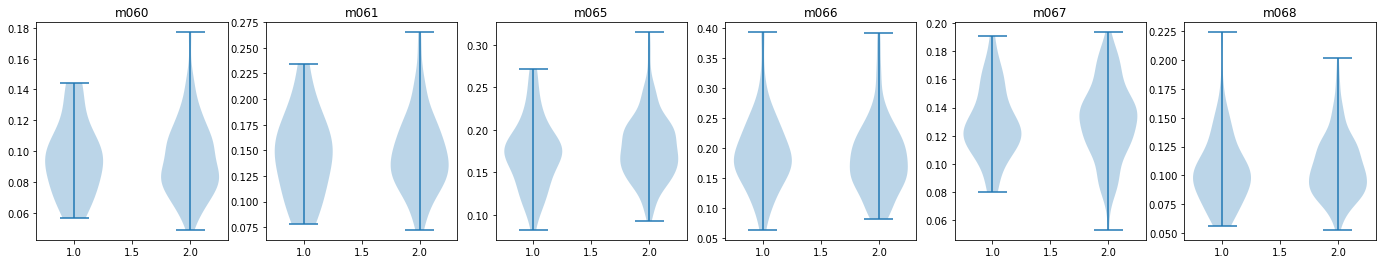

7 performance ; Significant Cells : NoReward


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.081981,0.082571,"(20, 133)",48,0.004714
1,m061,0.118092,0.115198,"(16, 74)",38,0.189646
2,m065,0.140629,0.142583,"(57, 181)",62,0.042430
3,m066,0.164255,0.158769,"(37, 151)",32,0.306479
4,m067,0.109926,0.111717,"(43, 154)",36,0.167718
5,m068,0.057439,0.062434,"(63, 175)",14,0.489228


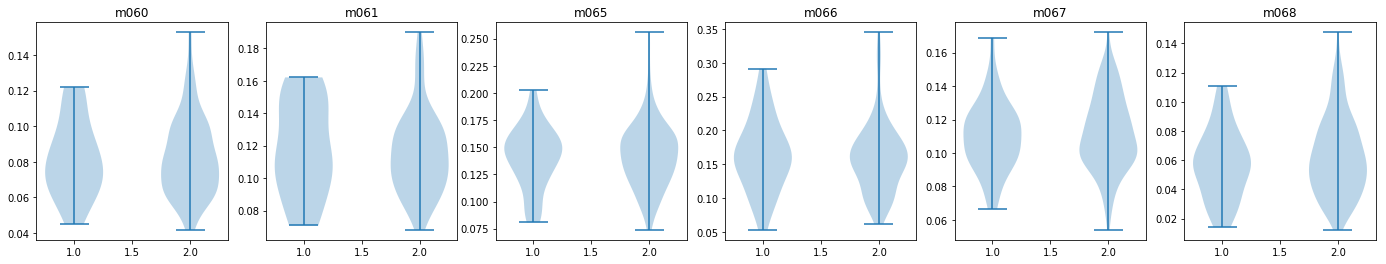

7 direction ; Significant Cells : None


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.081195,0.077450,"(79, 74)",88,0.645559
1,m061,0.117719,0.115221,"(45, 45)",46,0.152129
2,m065,0.129026,0.134252,"(122, 116)",83,0.726649
3,m066,0.147316,0.142349,"(86, 102)",47,0.435654
4,m067,0.122181,0.120834,"(90, 107)",49,0.135475
5,m068,0.074955,0.077488,"(126, 112)",28,0.350083


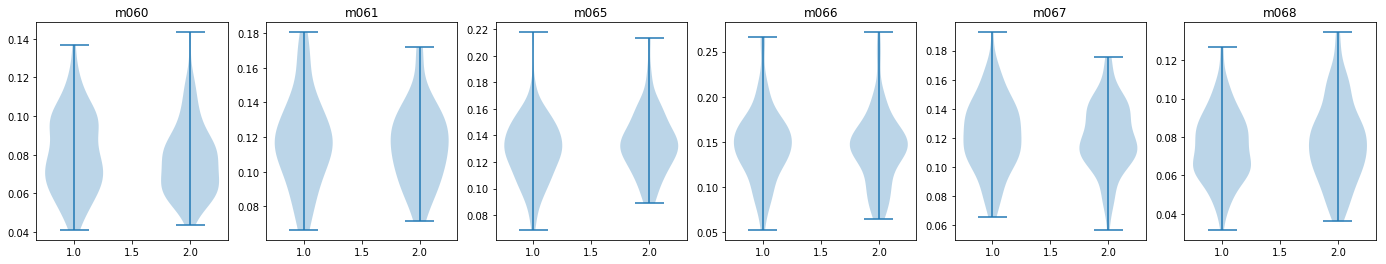

7 direction ; Significant Cells : Maintenance


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.098206,0.091661,"(79, 74)",52,1.173207
1,m061,0.147526,0.146092,"(45, 45)",26,-0.000000
2,m065,0.175591,0.179133,"(122, 116)",43,0.117810
3,m066,0.190495,0.180522,"(86, 102)",22,0.550889
4,m067,0.131502,0.129817,"(90, 107)",38,0.228780
5,m068,0.107570,0.105908,"(126, 112)",11,0.240566


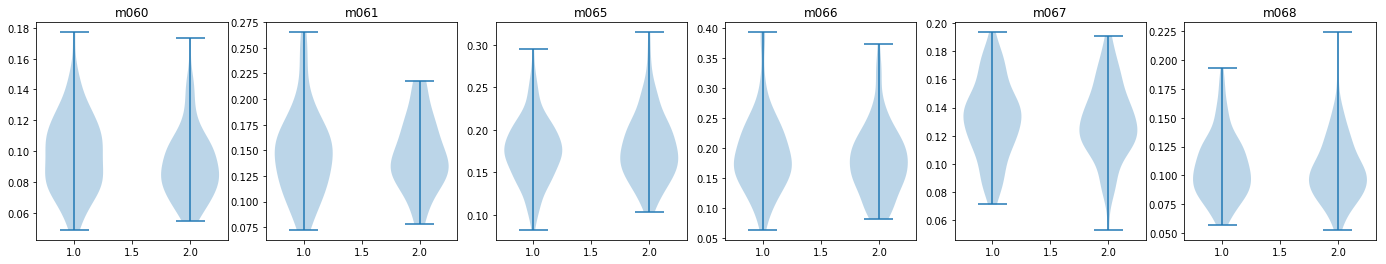

7 direction ; Significant Cells : NoReward


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.085206,0.079598,"(79, 74)",48,0.983603
1,m061,0.117773,0.113653,"(45, 45)",38,0.209821
2,m065,0.139307,0.145068,"(122, 116)",62,0.696269
3,m066,0.163157,0.157059,"(86, 102)",32,0.365198
4,m067,0.112492,0.110346,"(90, 107)",36,0.191471
5,m068,0.058916,0.063582,"(126, 112)",14,0.639827


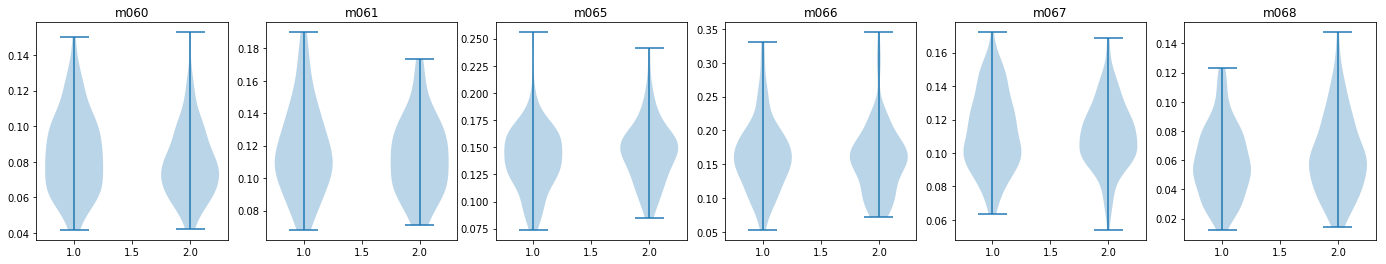

8 performance ; Significant Cells : None


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.068244,0.070614,"(20, 133)",88,0.103052
1,m061,0.112732,0.112255,"(16, 74)",46,0.020582
2,m065,0.111839,0.122343,"(57, 181)",83,3.479329
3,m066,0.129506,0.136277,"(37, 151)",47,1.080180
4,m067,0.116068,0.115500,"(43, 154)",49,0.118559
5,m068,0.079160,0.084600,"(63, 175)",28,1.291450


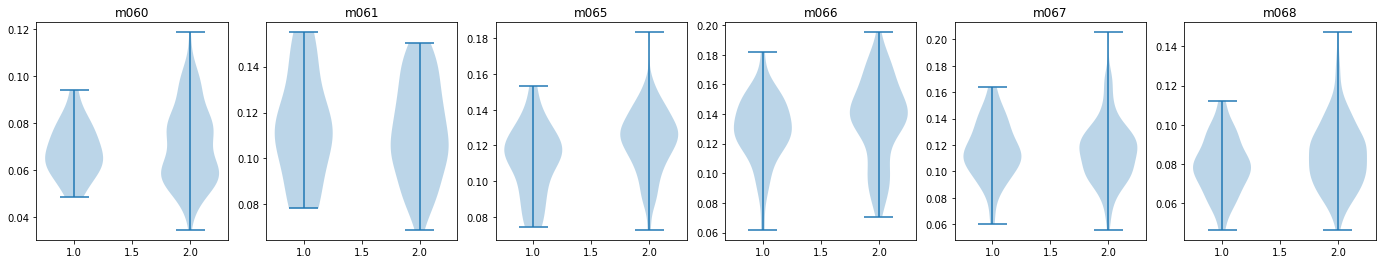

8 performance ; Significant Cells : Maintenance


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.074529,0.077916,"(20, 133)",52,0.188813
1,m061,0.145682,0.150366,"(16, 74)",26,0.205084
2,m065,0.146115,0.161164,"(57, 181)",43,3.497728
3,m066,0.149846,0.164339,"(37, 151)",22,1.870528
4,m067,0.123276,0.124016,"(43, 154)",38,0.025340
5,m068,0.103990,0.113950,"(63, 175)",11,1.978561


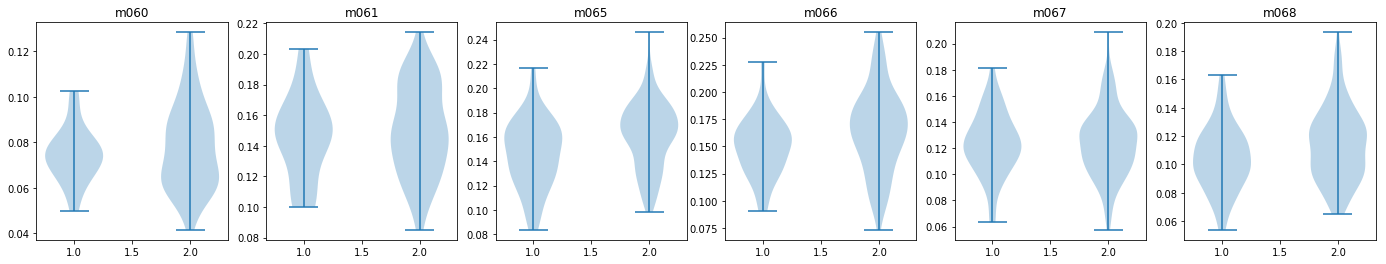

8 performance ; Significant Cells : NoReward


,mouse,Mistake,Correct,nTrials,nNeurons,-log10(pval)
0,m060,0.060998,0.061180,"(20, 133)",48,0.201974
1,m061,0.108967,0.105711,"(16, 74)",38,0.159714
2,m065,0.116743,0.128697,"(57, 181)",62,3.097535
3,m066,0.136160,0.144898,"(37, 151)",32,1.208870
4,m067,0.109157,0.109912,"(43, 154)",36,0.017643
5,m068,0.058421,0.062049,"(63, 175)",14,0.677116


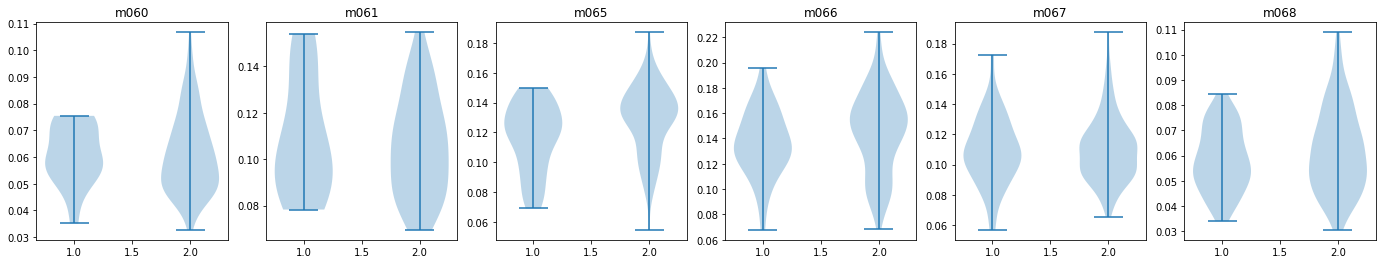

8 direction ; Significant Cells : None


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.071384,0.069152,"(79, 74)",88,0.352273
1,m061,0.111735,0.112944,"(45, 45)",46,0.116190
2,m065,0.118198,0.121542,"(122, 116)",83,0.860150
3,m066,0.137429,0.132850,"(86, 102)",47,0.332430
4,m067,0.114690,0.116410,"(90, 107)",49,0.184224
5,m068,0.081685,0.084820,"(126, 112)",28,0.849325


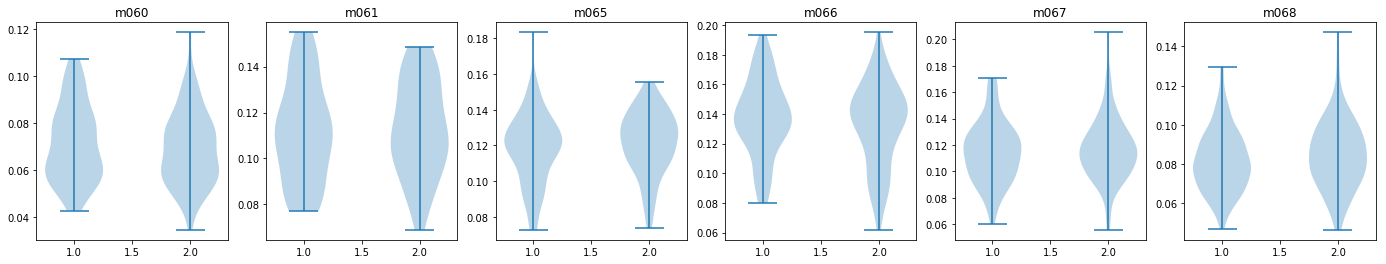

8 direction ; Significant Cells : Maintenance


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.078789,0.076069,"(79, 74)",52,0.345918
1,m061,0.147178,0.151889,"(45, 45)",26,0.441491
2,m065,0.156354,0.158827,"(122, 116)",43,0.371562
3,m066,0.162042,0.161018,"(86, 102)",22,0.066508
4,m067,0.122977,0.124592,"(90, 107)",38,0.094297
5,m068,0.109669,0.113164,"(126, 112)",11,0.519102


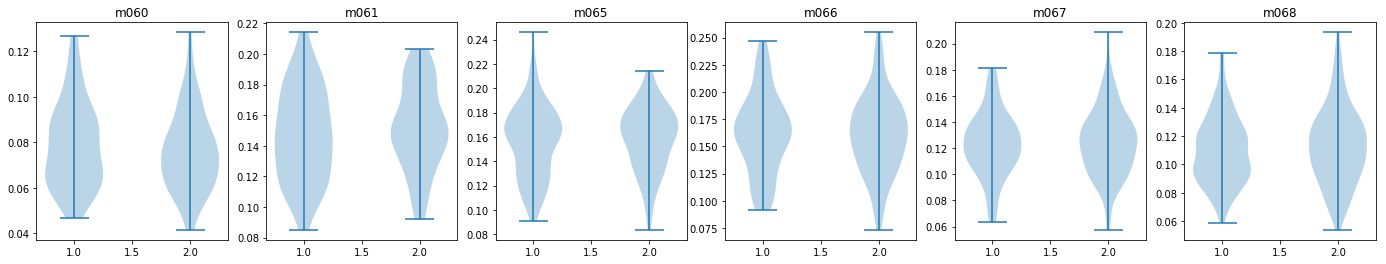

8 direction ; Significant Cells : NoReward


,mouse,L,R,nTrials,nNeurons,-log10(pval)
0,m060,0.061763,0.060509,"(79, 74)",48,0.234563
1,m061,0.106219,0.106361,"(45, 45)",38,0.025902
2,m065,0.124439,0.127302,"(122, 116)",62,0.490549
3,m066,0.146285,0.140559,"(86, 102)",32,0.487520
4,m067,0.108759,0.110579,"(90, 107)",36,0.281353
5,m068,0.059825,0.062510,"(126, 112)",14,0.696211


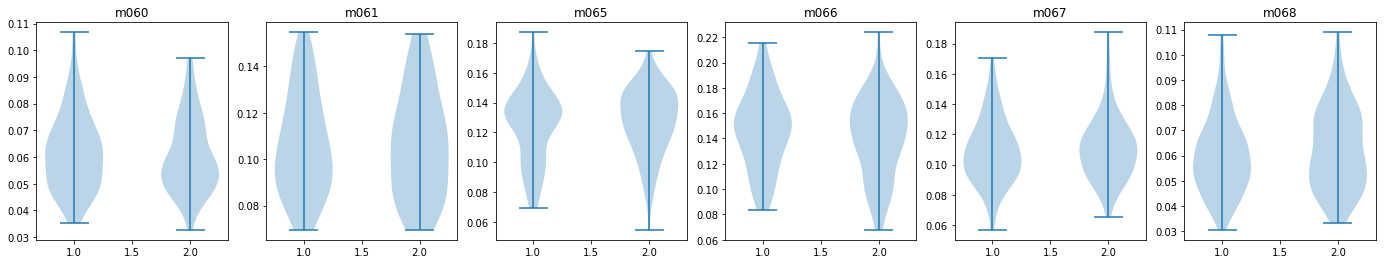

In [31]:
# selector = {"phase" : "Maintenance"}

for interval in range(6, 9):
    for condition in ["performance", "direction"]:
        for signCellsName, signCells in significantCellsSelector.items():
    #         print(condition, useSignificant)
            selector = {"interval" : interval}
            print(interval, condition, "; Significant Cells :", signCellsName)
            test_mean_time_and_neurons(dataDB, "deconv", selector, condition, signCellsMouseDict=signCells)

# 2 Time-Average

**Goal**: Attempt to predict LR/CM from average activities of individual cells.
* Count predictive cells in each mouse, phase/interval

In [32]:
def test_mean_time(dataDB, queryDict, selector, condition, nTest=1000, pval=0.01, signCellsMouseDict=None):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig1, ax1 = plt.subplots(ncols=nMice, figsize=(4*nMice, 4), tight_layout=True)
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        means = []
        
        if signCellsMouseDict is not None:
            channelFilter = signCellsMouseDict
            nCells = len(signCellsMouseDict[mousename])
        else:
            channelFilter = None
            nCells = dataDB.get_nchannel(mousename, queryDict['datatype'])
        
        for condVal in condValues:
            queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
            means += [metric_by_selector(dataDB, queryDictCond, "mean", "pr", selector, {}, channelFilter=channelFilter)]
            
        pValByCell, nCellSignificant, negLogPValPop = test_quantity(means[0], means[1], pval)
        mouseResults += [[mousename, nCellSignificant, nCells, np.round(negLogPValPop, 2)]]
        
        ax1[iMouse].plot(sorted(-np.log10(pValByCell)))
        ax1[iMouse].axhline(y=2, linestyle="--", color='r')
        ax1[iMouse].set_xlabel("cell index, sorted")
        ax1[iMouse].set_ylabel("-log10(pVal)")
        ax1[iMouse].set_title(mousename)
        
    display(pd.DataFrame(mouseResults, columns=["mouse", "nCellSignificant", "nCellTot", "pvalPopulation"]))
        
    plt.show()

6 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,15,88,13.80
1,m061,1,46,0.43
2,m065,17,83,16.96
3,m066,4,47,2.90
4,m067,0,49,0.00
5,m068,0,28,-0.00


/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


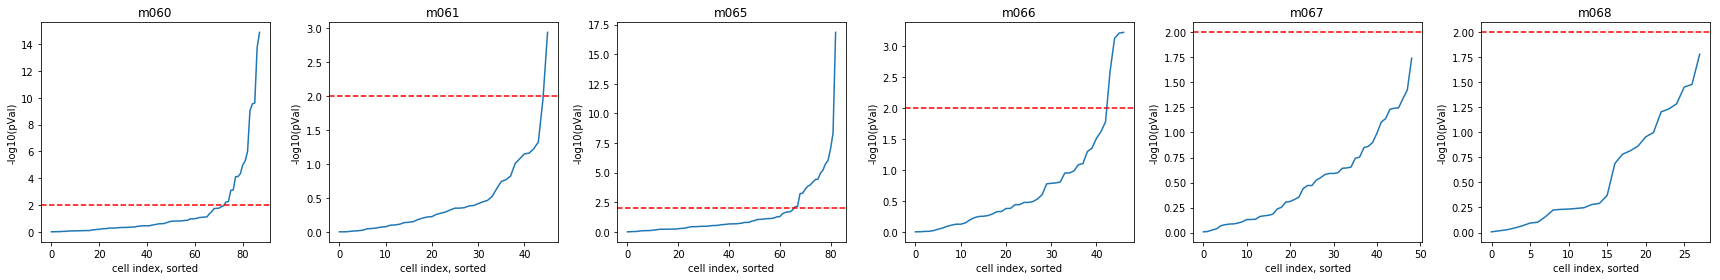

6 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,8,52,7.29
1,m061,0,26,-0.00
2,m065,7,43,6.63
3,m066,2,22,1.69
4,m067,0,38,-0.00
5,m068,0,11,0.00


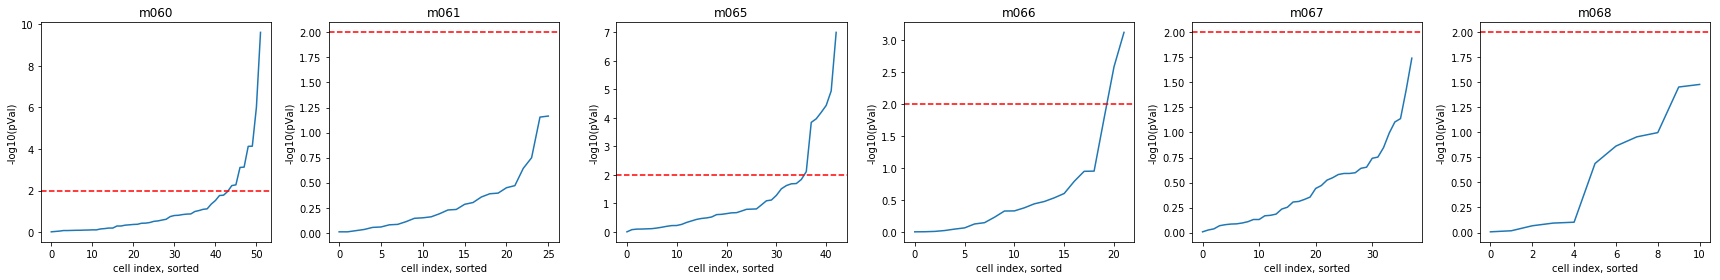

6 ; Significant Cells : NoReward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,9,48,8.93
1,m061,1,38,0.50
2,m065,12,62,11.87
3,m066,4,32,3.54
4,m067,0,36,-0.00
5,m068,0,14,-0.00


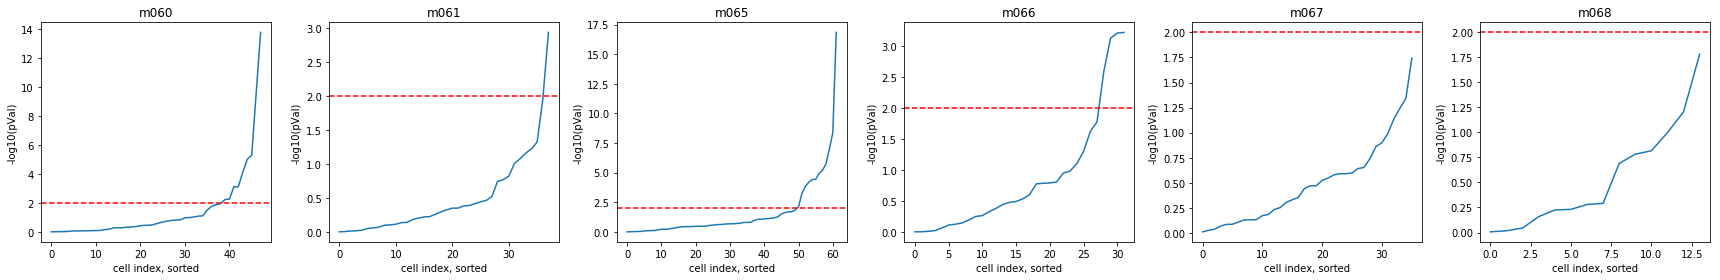

7 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,8,88,5.50
1,m061,1,46,0.43
2,m065,11,83,9.08
3,m066,2,47,1.09
4,m067,0,49,0.00
5,m068,0,28,-0.00


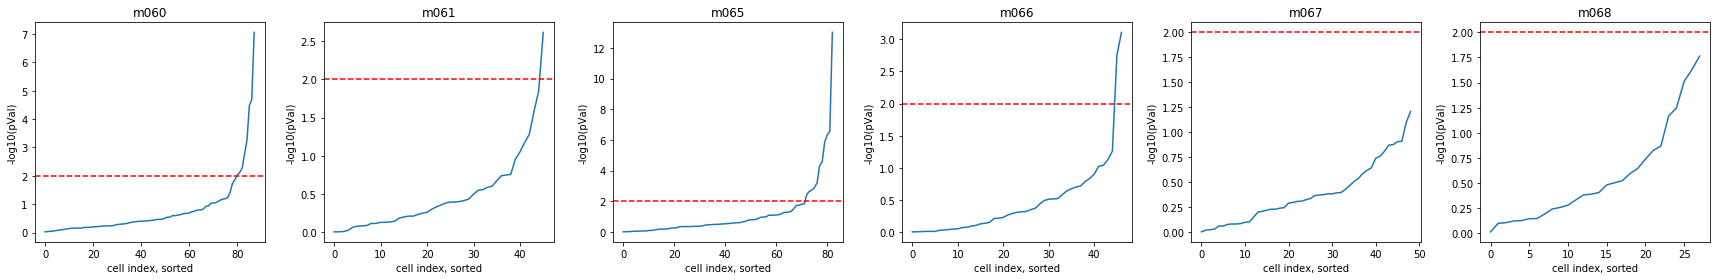

7 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,5,52,3.76
1,m061,1,26,0.64
2,m065,4,43,3.04
3,m066,0,22,-0.00
4,m067,0,38,-0.00
5,m068,0,11,0.00


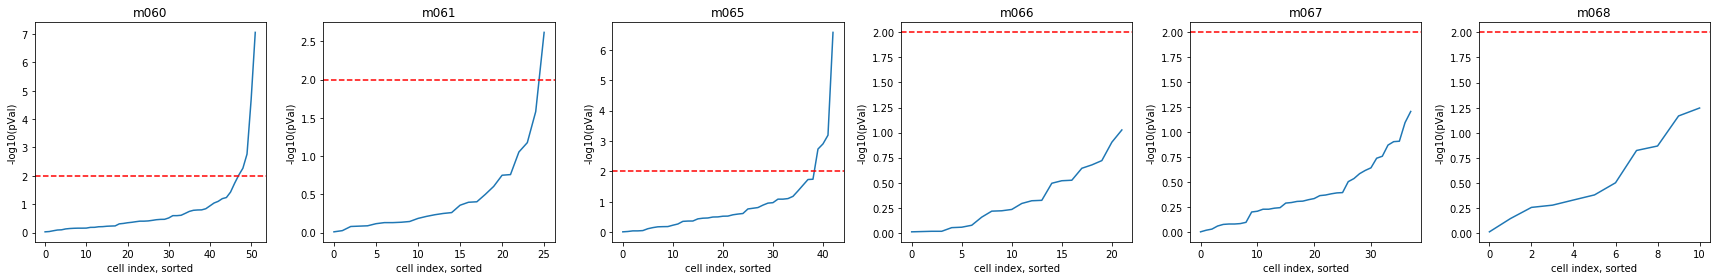

7 ; Significant Cells : NoReward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,4,48,2.86
1,m061,1,38,0.50
2,m065,7,62,5.52
3,m066,2,32,1.39
4,m067,0,36,-0.00
5,m068,0,14,-0.00


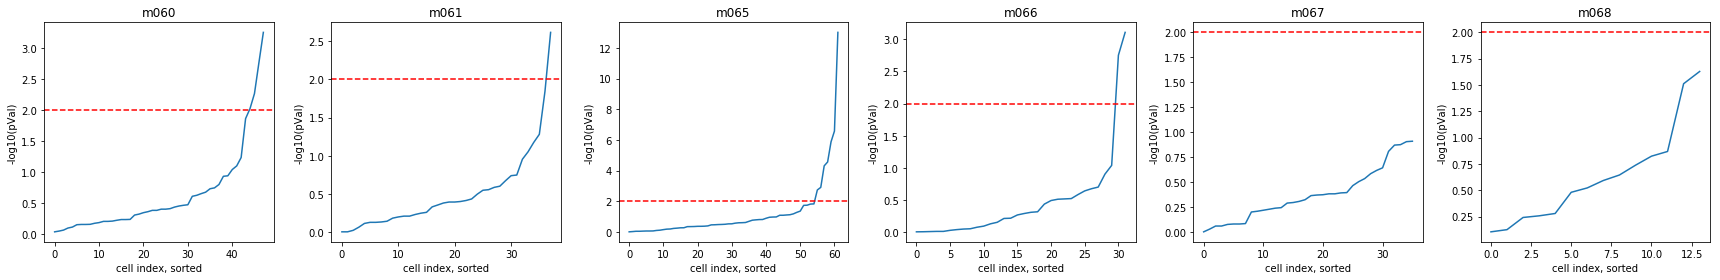

8 ; Significant Cells : None


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,88,0.00
1,m061,0,46,0.00
2,m065,7,83,4.67
3,m066,0,47,-0.00
4,m067,2,49,1.06
5,m068,0,28,-0.00


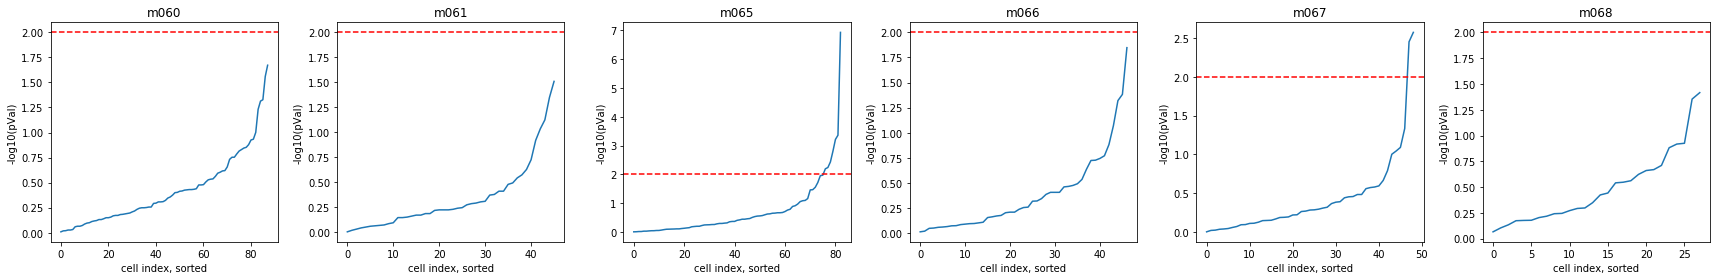

8 ; Significant Cells : Maintenance


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,52,-0.00
1,m061,0,26,-0.00
2,m065,1,43,0.45
3,m066,0,22,-0.00
4,m067,0,38,-0.00
5,m068,0,11,0.00


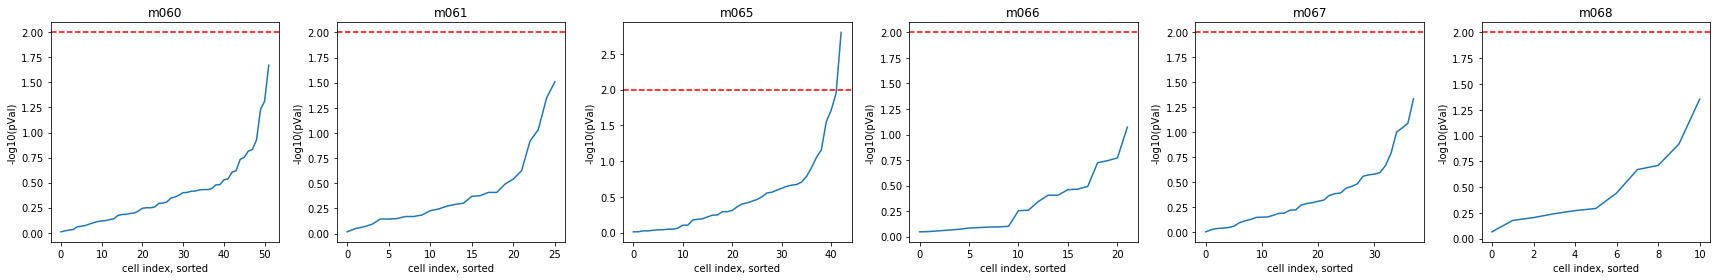

8 ; Significant Cells : NoReward


,mouse,nCellSignificant,nCellTot,pvalPopulation
0,m060,0,48,0.00
1,m061,0,38,-0.00
2,m065,5,62,3.39
3,m066,0,32,0.00
4,m067,1,36,0.52
5,m068,0,14,-0.00


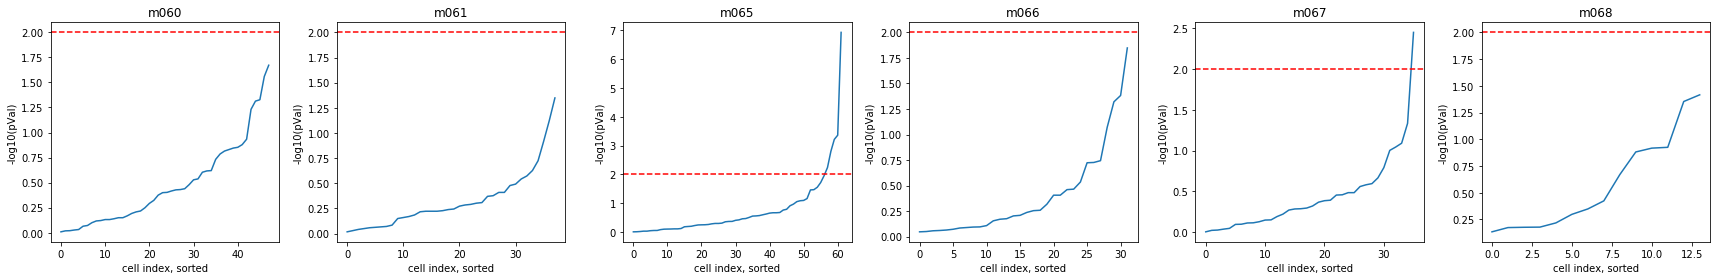

In [33]:
queryDict = {"datatype" : "raw", "performance" : "Correct"}
# queryDict = {"datatype" : "raw", "direction" : "R"}

# selector = {"phase" : "Maintenance"}

for interval in range(6, 9):
    for signCellsName, signCells in significantCellsSelector.items():
#         print(condition, useSignificant)
        selector = {"interval" : interval}
        print(interval, "; Significant Cells :", signCellsName)
        test_mean_time(dataDB, queryDict, selector, "direction", signCellsMouseDict=signCells)

## 2.1 LRCM discrimination by phase/interval

Calculating mouse m060
Calculating mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; 

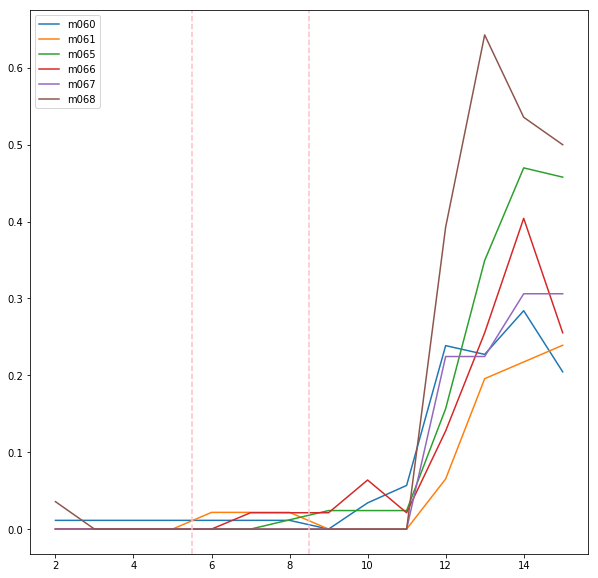

In [35]:
def test_ncells_by_interval(dataDB, queryDict, condition, intervRange, nTest=1000, pval=0.01):
    nMice = len(dataDB.mice)
    condValues = set(dataDB.metaDataFrames['behaviorStates'][condition])
    mouseResults = []
    
    fig, ax = plt.subplots(figsize=(10,10))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Calculating mouse", mousename)
        
        freqCellSignificant = []
        for iInterv in intervRange:
            selector = {"interval" : iInterv}
        
            means = []
            for condVal in condValues:        
                queryDictCond = {**queryDict, **{"mousename" : mousename, condition : condVal}}
                means += [metric_by_selector(dataDB, queryDictCond, "mean", "pr", selector, {})]

            nCells = means[0].shape[0]
            _, nCellSignificant, _ = test_quantity(means[0], means[1], pval)
            freqCellSignificant += [nCellSignificant / nCells]
            
        ax.plot(np.array(intervRange)+1, freqCellSignificant, label=mousename)

    ax.axvline(x=5.5, linestyle='--', color='pink')
    ax.axvline(x=8.5, linestyle='--', color='pink')
    plt.legend()
    plt.savefig('interval_freq_significant_cells_'+condition+'.pdf')
    plt.show()
    
queryDict = {"datatype" : "raw", "direction" : "R"}
# queryDict = {"datatype" : "raw", "performance" : "Correct"}
test_ncells_by_interval(dataDB, queryDict, "performance", range(1, 15))

## 2.3 Significant Cell Confusion matrices

In [36]:
def text_different_one(data2D, i):
    dataThis = data2D[i]
    dataOther = np.hstack(data2D[:i] + data2D[i+1:])
    T, p = rstest_twosided(dataThis, dataOther)
    return -np.log10(p)


def text_different(data2D):
    return np.array([text_different_one(data2D, i) for i in range(len(data2D))])


# Calculate confusion matrix
def significance_confusion_matrix(sign2D):
    nCell, nPhase = sign2D.shape  # A boolean array reporting if a given cell is significant in a given phase
    confMat = np.zeros((nPhase, nPhase))
    for i in range(nPhase):
        for j in range(nPhase):
            confMat[i][j] = np.sum(np.logical_and(sign2D[:, i], sign2D[:, j]))
    return confMat


def confusion_matrices_LRCM(queryDict, selector):
    settings = {"zscoreChannel" : False, "serial" : True, "metricSettings" : {}}

    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(4*len(dataDB.mice), 4), tight_layout=True)
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print('doing mouse', mousename)

        keys = []
        rezLst = []
        for performance in ['Correct', 'Mistake']:
            for direction in ['L', 'R']:
                keys += [str((performance, direction))]
                queryDictThis = {**queryDict, **{'mousename' : mousename, 'performance' : performance, 'direction' : direction}}
                rezLst += [metric_by_selector(dataDB, queryDictThis, 'mean', 'pr', selector, settings)]
                
        nChannel = len(rezLst[0])
        pVals2D = np.array([text_different([rez[iCh] for rez in rezLst]) for iCh in range(nChannel)])

        # Calculate confusion matrix
        sign2D = pVals2D > 2
        confMat = significance_confusion_matrix(sign2D)

        # Plot confusion matrix
        imshow(fig, ax[iMouse], confMat, limits=[0, nChannel], title=mousename, haveColorBar=True, cmap='jet',
               haveTicks=True, xTicks=keys, yTicks=keys)

    fig.savefig('interval_'+ str(selector["interval"]) +'_significant_cells_confusion.pdf')
    #plt.show()
    plt.close()

In [37]:
for iInterv in range(5, 10):
    confusion_matrices_LRCM({"datatype" : "deconv"}, {"interval" : iInterv})

doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
doing mouse m065
doing mouse m066
doing mouse m067
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
doing mouse m068
doing mouse m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
doing mouse m061
No behaviour 

# 3. Scalar metric tests

**Goal**: Evaluate predictive power for several metrics
* Stretch hypothesis: Legendre Basis (try several bases individually up to 6)
* Synchronization hypothesis: AvgCorr, H

## Table

**TODO**: Fix NAN, test

In [38]:
%%time
dataDB.verbose = False

#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}
settings = {"serial" : True, "metricSettings" : {"max_lag" : 1}}
sweepDict = {
    "datatype": ["deconv"],
    "performance": ["Correct", "Mistake", "All"],
#     "direction": ["L", "R", "All"]
}
# selector = {"phase" : "Maintenance"}
selector = {"interval" : 9}

table_lib.table_discriminate_behavior(dataDB, selector, "direction",
                                      sweepDict,
                                      "mean",
                                      trgDimOrder="r",
                                      settings=settings,
                                      multiplexKey="mousename",
                                      channelFilter=None)

,-logp(L->R),datatype,mu(L),mu(R),performance
0,0.221560,deconv,NaN,NaN,Correct
1,1.121315,deconv,0.094697,0.084383,Mistake
2,0.169473,deconv,NaN,NaN,All


CPU times: user 522 ms, sys: 4.03 ms, total: 526 ms
Wall time: 527 ms


## Violins

For ('Mistake', 'Correct') of data size (114, 434) rank-sum-test is 0.0007104739231471268


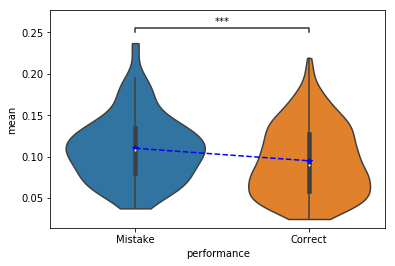

In [40]:
def binary_test_phase(dataDB, queryDict, condition, selector, metricName, settings):
    condValues = list(set(dataDB.metaDataFrames['behaviorStates'][condition]))
    
    rezLst = []
    for condVal in condValues:
        queryDictCond = {**queryDict, **{condition : condVal}}
        rezLst += [metric_by_selector(dataDB, queryDictCond, metricName, "r", selector, {})]
        
    fig, ax = plt.subplots()
    plots_lib.plot_labeled_violins(ax, rezLst, condValues, condition, metricName,
                                   joinMeans=True, haveLog=False, sigTestPairs=[(0,1)])
    
    
#settings = {"serial" : True, "metricSettings" : {"metric" : num_sample}}
settings = {"serial" : True, "metricSettings" : {}}
queryDict = {"datatype" : "deconv", "direction" : "L"}

binary_test_phase(dataDB, queryDict, "performance", {"interval" : 9}, "mean", settings)
#binary_test_phase(dataDB, queryDict, "direction", ["L", "R"], "Maintenance", settings)

# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

In [3]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"serial": True, "metricSettings": None}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings)

rez

NameError: name 'plots_lib' is not defined

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)